# Objectifs du projet

Fruits! est une jeune start-up appartenant au secteur l'AgriTech qui souhaite proposer de nouvelles façons de récolter les fruits. Son ambition est de préserver la biodiversité fruitière en développant des robots cueilleurs intelligents, capables d’adapter leurs modes de traitement à chaque espèce, afin de garantir une récolte plus respectueuse et optimisée. 

Dans une première étape, la start-up souhaite accroître sa visibilité auprès du grand public en lançant une application mobile interactive. Cette application offrira aux utilisateurs la possibilité de photographier un fruit et de recevoir immédiatement des informations détaillées à son sujet, telles que son espèce, ses caractéristiques et son origine. Pour la start-up, cette application permettra de sensibiliser le grand public à la biodiversité des fruits et de développer et tester une première version d'un moteur de classification des images de fruits. 

Pour répondre à cette objectif, une première chaine de traitement comprenant le préprocessing, une étape d'extraction de caractéristiques et une étape de réduction de dimension sera mise en place. De plus, la start-up souhaite anticiper une croissance rapide du volume de données une fois l’application déployée. Il sera donc essentiel de concevoir une solution évolutive et distribuable. Dans cette optique, les étapes suivantes consisteront à concevoir une solution capable de gérer l'augmentation des donner puis à déployer la chaîne de traitement dans un environnement Big Data.
 
Le projet sera donc réalisé en 2 temps, dans deux environnements différents. Le code sera dans un premier temps développé et exécuté en local, en utilisant un échantillon réduit d'images puis une fois les choix techniques validés, la solution sera déployée dans un envirronement BigData pour exécuter le traitement à grande échelle. 

<u>Pour cette raison, ce projet sera divisé en 2 notebooks</u>:
1. un notebook executant la solution en local
2. un notebook executant la solution dans le cloud

# Sommaire

- [1 Objectifs du projet](#Objectifs-du-projet)
- [2 Sommaire](#Sommaire)
- [3 Import](#Import-des-librairies)
- [4  Choix et initialisation de l'environnement de travail](#Choix-et-initialisation-de-l'envirronement-de-travail)
- [5 Définition des PATH pour charger les images et enregistrer les résultats](#Définition-des-PATH-pour-charger-les-images-et-enregistrer-les-résultats)
- [6 Chargement des données](#Chargement-des-données)
- [7 Préparation du modèle](#Préparation-du-modèle)
- [8 Extraction des caractéristiques](#Extraction-des-caractéristiques)
- [9 Réduction de la dimensionnalité des vecteurs de caractéristiques](#Réduction-de-la-dimensionnalité-des-vecteurs-de-caractéristiques)
- [10 Conclusions](#Conclusions)

# Import des librairies

In [1]:
# Librairies standard
import os
import io

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Manipulation de données
import pandas as pd
import numpy as np

# Image
from PIL import Image

# Visualisation
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model

# PySpark 
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split, udf 
from pyspark.sql.window import Window
from pyspark.sql.types import FloatType, ArrayType
from pyspark.sql import functions as F
from pyspark.ml.feature import PCA, VectorAssembler, StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml import Pipeline
from pyspark.ml.functions import vector_to_array


# Choix et initialisation de l'envirronement de travail

Afin d'anticiper l'augmentation rapide du volume de données prévus après la livraison du projet, les scripts seront développés en PySpark. Cette approche permettra de créer une solution scalable et capable de passer facilement d’un traitement local à un traitement distribué sur un cluster.

L'outil PySpark correspond à la version Python du moteur Apache Spark, un framework open source de calcul distribué en mémoire, conçu pour le traitement et l’analyse de données massives. Concrètement, Spark permet de répartir l’exécution d’un même programme sur plusieurs machines, en coordonnant les calculs et les échanges de données de manière optimisée.

Le fonctionnement de Spark repose sur trois éléments principaux :
- Le driver qui orchestre le traitement, planifie les tâches et distribue leur exécution sur les différents noeuds.
- Le cluster manager qui alloue les ressource nécessaire à l'execution du programme.
- Les exécuteurs, qui sont des processus indépendants responsables de l’exécution concrète des tâches. Chacun dispose de ressources configurables (CPU, mémoire) et traite un fragment des données en parallèle.

Dans ce projet, Spark sera donc utilisé dans les deux environnements :
- Dans un environnement local, pour simuler le calcul distribué et valider la chaîne de traitement sur un échantillon de données.
- Sur le cloud, pour exécuter le pipeline sur un cluster réel, exploitant pleinement les capacités du calcul distribué.

## Environnement de travail

Pour des raisons de simplicité, le code a été développé dans un environnement Linux Unbuntu (exécuté depuis une machine Windows dans une machine virtuelle) sur lequel pyspark a été installé

## Création de la SparkSession

L’application Spark est contrôlée grâce à un processus de pilotage (driver process) appelé SparkSession. Une instance de SparkSession est la façon dont Spark exécute les fonctions définies par l’utilisateur dans l’ensemble du cluster.

<u>La session spark sera créée en spécifiant dans l'ordre</u> :
 1. un nom pour l'application, qui sera affichée dans l'interface utilisateur Web Spark "P9"
 2. que l'application doit s'exécuter localement. Le nombre de coeur à utiliser ne sera pas définit et tout les coeurs disponibles du processeur seront donc utilisés.
 3. une option de configuration supplémentaire permettant d'utiliser le format "parquet" qui sera utilisé pour enregistrer et charger le résultat du projet.
 4. vouloir obtenir une session spark existante ou si aucune n'existe, en créer une nouvelle
 
La variable sc, qui correspond au SparkContext issu de spark, est ensuite créée pour permettre d’accéder au moteur d’exécution de Spark. Elle sert à gérer les tâches réparties, contrôler les ressources et interagir avec les données distribuées, tout en offrant des outils pour surveiller et optimiser le traitement.

In [2]:
# Création de la session spark
spark = (SparkSession
             .builder
             .appName('P9')
             .master('local')
             .config("spark.sql.parquet.writeLegacyFormat", 'true')
             .config("spark.network.timeout", "600s") \
             .config("spark.executor.heartbeatInterval", "60s") 
             .getOrCreate()
)

# Création de la variable SparkContext
sc = spark.sparkContext

# Affichage des informations de la session spark en cours d'execution
spark

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/15 13:47:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Définition des PATH pour charger les images et enregistrer les résultats

Afin de mieux gérer les différents import de données et export de résultat, on va commencer par définir les paths qui seront utilisés. Pour commencer, on récupère le répertoire courant du script avec os.getcwd() puis on identifie le dossier parent grâce à os.path.dirname() ce qui permettra de construire les chemins vers les sous-dossiers de données et de résultats : Test_Local, qui contient les images qui seront traitées dans cet environnement local, et Results, destiné à stocker les résultats du traitement.

In [3]:
# Répertoire courant du script
PATH = os.getcwd()

# Dossier parent
PARENT = os.path.dirname(PATH)

# Chemins vers les sous-dossiers "data" et "Output" situés dans le dossier parent
PATH_Data = os.path.join(PARENT, 'Data/Test_local')
PATH_Result_features_pq = os.path.join(PARENT, 'Output/Test_local/Features')
PATH_Result_PCA_pq = os.path.join(PARENT, 'Output/Test_local/PCA')
PATH_Result_PCA_csv = os.path.join(PARENT, 'Output/Test_local/PCA')
PATH_Result_projection = os.path.join(PARENT, 'Output/Test_local/Projections')

# Affichage des chemins des dossiers
print(f"PATH:                      {PATH}")
print(f"PATH_Data:                 {PATH_Data}")
print(f"PATH_Result_features_pq:   {PATH_Result_features_pq}")
print(f"PATH_Result_PCA_pq:        {PATH_Result_PCA_pq}")
print(f"PATH_Result_PCA_csv:       {PATH_Result_PCA_csv}")
print(f"Path_Result_projection:    {PATH_Result_projection}")

PATH:                      /home/aline-vitrac/Documents/sf_Projet9/Notebooks
PATH_Data:                 /home/aline-vitrac/Documents/sf_Projet9/Data/Test_local
PATH_Result_features_pq:   /home/aline-vitrac/Documents/sf_Projet9/Output/Test_local/Features
PATH_Result_PCA_pq:        /home/aline-vitrac/Documents/sf_Projet9/Output/Test_local/PCA
PATH_Result_PCA_csv:       /home/aline-vitrac/Documents/sf_Projet9/Output/Test_local/PCA
Path_Result_projection:    /home/aline-vitrac/Documents/sf_Projet9/Output/Test_local/Projections


# Chargement des données

Les images sont dans un premier temps, importées au format binaire, un format qui offre une plus grande flexibilité pour le prétraitement. Lors de l'import, une option peut être utilisée pour choisir le format des images que l'on souhaiter charger, ainsi seul les fichiers du format spécifié sont pris en compte et on ne chargera que les images de ce format. Une autre option permet de charger tous les objets présents dans les sous-dossiers du répertoire indiqué sont, ce qui facilite le traitement récurcif de l’ensemble de la structure de données et la centralisation toutes les images disponibles pour l’étape suivante de traitement.

In [4]:
# Chargement des images
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

# Ajout d'une colonne correspondant au label des images
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

# Affichage de 
print(images.printSchema())

# Affichage des 5 premières images
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None


+---------------------------------------------------------------------------------------+-----------+
|path                                                                                   |label      |
+---------------------------------------------------------------------------------------+-----------+
|file:/home/aline-vitrac/Documents/sf_Projet9/Data/Test_local/Cauliflower/r_180_100.jpg |Cauliflower|
|file:/home/aline-vitrac/Documents/sf_Projet9/Data/Test_local/Cauliflower/r_172_100.jpg |Cauliflower|
|file:/home/aline-vitrac/Documents/sf_Projet9/Data/Test_local/Cauliflower/r2_208_100.jpg|Cauliflower|
|file:/home/aline-vitrac/Documents/sf_Projet9/Data/Test_local/Cauliflower/r_230_100.jpg |Cauliflower|
|file:/home/aline-vitrac/Documents/sf_Projet9/Data/Test_local/Cauliflower/r2_212_100.jpg|Cauliflower|
+---------------------------------------------------------------------------------------+-----------+
only showing top 5 rows
None


Le tableau contient l’ensemble des images chargées, avec pour chacune son chemin d’accès (path) associé, la date et l’heure de sa dernière modification, sa longueur ainsi que son contenu. Cette structure garantie une bonne tracabilité des fichiers : elle permet de conserver une référence claire vers l’emplacement original de chaque image, de vérifier leur date de mise à jour, et de garantir la cohérence entre les données brutes et leurs traitements ultérieurs.

# Préparation du modèle

Dans ce projet, les images seront prétraitées pour qu'un modèle extrait leur caractéristique dont la dimensionnalité sera ensuite réduite. Il ne sera pas à ce stade nécessaire d'entrainer un modèle. Pour cela, la technique de transfert learning sera utilisée. Cette technique consiste à exploiter les connaissances d’un modèle préentraîné, ici MobileNetV2, et à les adapter à la problématique spécifique du projet.

## Chargement et préparation du modèle

Le modèle est dans un premier temps chargé et configuré pour recevoir les images avec une dimension de 224×224×3. Dans l'étape suivante, le modèle est adapté pour la tâche d'extraction de caractéristiques. Pour cela, la dernière couche softmax, qui réalise la classification selon les 1000 catégories d'ImageNet, n’est pas utilisée, car l’objectif ici est uniquement d’extraire les caractéristiques. Cette étape permet de récupérer la sortie de l’avant-dernière couche et d'obtenir un vecteur de caractéristiques de dimension (1,1,1280). 

Dans ce projet, le modèle selectionné correspond à MobileNetV2, un modèle caractérisé par une execution rapide et une dimensionnalité de son vecteur de caractéristique relativement faible. 

Le modèle est donc chargé avec les poids précalculés sur ImageNet, puis un nouveau modèle est créé en conservant l’entrée originale et en définissant la sortie sur l’avant-dernière couche pour permettre l’extraction des features.

In [5]:
# Chargement du modèle 
model = MobileNetV2(weights='imagenet',
                    include_top=True,
                    input_shape=(224, 224, 3))

2025-12-15 13:48:54.680242: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
# Adaptation du modèle à la tache d'extraction de caractéristique
new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)

# Affichage de l'architecture du modèle
new_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

L'affichage du résumé du nouveau modèle permet de constaster que la sortie récupérée en sortie correspond bien à un vecteur de dimension (1,1,1280)

Comme les calculs seront exécutés de manière distribuée, il est important que tous les workers puissent accéder au modèle et à ses poids. Une bonne pratique consiste à charger le modèle sur le driver puis à diffuser les poids aux différents workers, afin de garantir que chaque worker utilise exactement le même modèle pour l’extraction des caractéristiques et que les résultats soient cohérents à travers l’ensemble du cluster.

In [7]:
# Diffusion des poids au workeurs
brodcast_weights = sc.broadcast(new_model.get_weights())

## Fonction pour charger le modèle et diffuser ses poids aux workers


In [8]:
def model_fn():
    
    """
    Crée un modèle MobileNetV2 avec les poids fournis par pyspark et gèle toutes les 
    couches existantes sauf la dernière couche avant la sortie.

    Cette fonction permet d'utiliser MobileNetV2 comme extracteur de  caractéristiques 
    dans un contexte de transfert de connaissances tout en initialisant le modèle avec 
    des poids partagés via Spark Broadcast.

    Paramètres
        - broadcast_weights (pyspark.Broadcast): Objet broadcast contenant les poids à utiliser pour initialiser le modèle.

    Sortie
        - tensorflow.keras.Model: Nouveau modèle Keras avec les couches gelées et les poids initialisés.
    """
        
    # Création du modèle MobileNetV2 sans poids pré-entraînés
    model = MobileNetV2(weights=None,
                        include_top=True,
                        input_shape=(224, 224, 3))
    
    # Gel des couches pour empêcher leur entraînement
    for layer in model.layers:
        layer.trainable = False
        
    # Création d'un nouveau modèle dont la sortie est l'avant-dernière couche
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    
    # Chargement des poids diffusés depuis le driver vers tous les exécuteurs
    new_model.set_weights(brodcast_weights.value)
    
    return new_model

# Extraction des caractéristiques

Pour pouvoir extraire les caractéristiques des images de manière efficace, plusieurs étapes seront suivies. Dans un premier temps, les images brutes seront prétraitées afin de les rendre compatibles avec le modèle MobileNetV2 (ouverture, redimensionnement, conversion en tableau numérique puis normalisation). Ensuite, le modèle sera appliqué aux images prétraitées pour générer des vecteurs numériques de features représentant les informations visuelles de chaque image.

## Fonction utilisées

Pour cela, deux fonctions sont définies : 
- La première fonction permettra de prétraiter les images
- La seconde fonction permettra d'appliquer le modèle à une série d’images pour extraire leur caractéristiques.

Pour tirer partie du calcul distribué offert par l'environnement PySpark, la fonction d'extraction de caractéristiques sera définie comme une Pandas UDF avec le décorateur @pandas_udf('array<float>', PandasUDFType.SCALAR_ITER) ce qui permettra à Spark de traiter les images par lots (batches) sous forme de séries Pandas et donc d'accélérer la vitesse de traitement des images.

In [9]:
def preprocess(content):
    """
    Prétraite le contenu brut d'une image pour le rendre compatible avec MobileNetV2.

    Étapes réalisées :
    1. Ouvre l'image à partir des octets bruts (bytes) fournis.
    2. Redimensionne l'image à 224x224 pixels, dimension attendue par MobileNetV2.
    3. Convertit l'image en un tableau NumPy à 3 dimensions (hauteur, largeur, canaux).
    4. Applique la fonction de prétraitement de MobileNetV2 (normalisation spécifique).

    Paramètres
        -content (bytes): Contenu brut de l'image (fichier image lu en binaire).

    Sortie
        - np.ndarray: Tableau NumPy prétraité et prêt à être utilisé comme entrée du modèle.
    """
    
    # Ouverture de l'image à partir des bytes et redimensionnement
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    
    # Conversion de l'image en tableau NumPy
    arr = img_to_array(img)
    
    # Application du prétraitement spécifique à MobileNetV2 et sortie du tableau
    return preprocess_input(arr)

In [10]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    """
    Scalar Iterator pandas UDF pour prétraiter les images et extraire les features
    avec MobileNetV2 dans un contexte Spark distribué.
    
    Paramètres
        - Itérateur sur des batches de données, chaque batch
          étant une pandas Series contenant des images brutes.
    
    Sortie 
        - Series Spark contenant les vecteurs de features pour chaque image.
    """
    
    # Chargement du modèle sur le worker
    model = model_fn()
    
    # Pour chaque batch
    for content_series in content_series_iter:
        
        # Prétraitement des images : ouverture, redimensionnement, conversion en array et normalisation
        input_array = np.stack(content_series.map(lambda content: preprocess(content)))
        
        # Extraction des features avec le modèle
        preds = model(input_array, training=False).numpy()
        
        # Aplatissement des tenseurs multi-dimensionnels pour faciliter le stockage dans Spark
        features = [p.flatten() for p in preds]
        
        yield pd.Series(features)


/home/aline-vitrac/envP9/lib/python3.12/site-packages/pyspark/sql/pandas/functions.py:446: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


##  Exécution des actions d'extraction de features

Dans cette étape, la fonction permettant d'extraire les caractéristiques des images est appliquées aux données. Pour que ces traitements soit effectués de façon distribué, on utilisera la méthode images.repartition(20) ce qui permettra de redistribuer les données sur 20 partitions dans le cluster Spark. Cela permet à Spark de paralléliser le traitement des images sur plusieurs noeuds ou coeur, ce qui accélère considérablement le calcul des features, surtout lorsque le jeu de données est volumineux. Cette méthode sera donc particulièrement utile lorsque les traitements seront effectués à plus grande échelle sur le cloud.

Une fois les features extraites, les résultats sont sauvegardés au format Parquet qui permet un stockage efficace, un accès rapide aux colonnes et une compression automatique des données pour économiser de l’espace. De plus ce format est compatible avec Spark et d'autres outil BigData.

In [11]:
# Extraction des features des images de la dataframe
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

In [12]:
# Enregistrement des données au format parquet
features_df.write.mode("overwrite").parquet(PATH_Result_features_pq)

2025-12-15 13:50:04.526771: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
                                                                                

##  Chargement des données enregistrées et validation du résultat


In [13]:
# Chargement des données enregistrées dans un dataframe Pandas
df = pd.read_parquet(PATH_Result_features_pq, engine='pyarrow')

# Affichage des 5 premières lignes du dataframe
df.head()

,path,label,features
0,file:/home/aline-vitrac/Documents/sf_Projet9/D...,Cauliflower,"[0.0, 0.58183324, 1.9379085, 0.0, 0.0, 0.0, 0...."
1,file:/home/aline-vitrac/Documents/sf_Projet9/D...,Cauliflower,"[0.0, 0.29475933, 2.8602803, 0.0, 0.0, 0.00212..."
2,file:/home/aline-vitrac/Documents/sf_Projet9/D...,Cauliflower,"[0.0, 0.20428912, 3.0310173, 0.0, 0.15524738, ..."
3,file:/home/aline-vitrac/Documents/sf_Projet9/D...,Avocado,"[1.2094374, 0.0, 0.0007484689, 0.03162961, 0.0..."
4,file:/home/aline-vitrac/Documents/sf_Projet9/D...,Avocado,"[0.5599701, 0.0, 0.25696173, 0.0, 0.0, 0.0, 0...."


On peut maintenant vérifier le format des caractéristiques extraites par le modèle à l’étape précédente. Celles-ci sont stockées sous forme de liste dans la dernière variable de la DataFrame. Il faut donc extraire cette liste afin d’en analyser le format.

In [14]:
# Affichage de la dimension du vecteur de caractéristiques 
df.loc[0,'features'].shape

(1280,)

In [15]:
# Affichage de la forme de la dataframe
df.shape

(300, 3)

Les caractéristiques extraites à l’étape précédente ont bien une dimension de 1 280, ce qui correspond à la taille attendue de la sortie du modèle ce qui démontre que l’extraction des features s’est déroulée correctement.

Il serait maintenant intéressant de réduire la dimensionnalité de ces données à l’aide d’une méthode telle que la PCA afin de pouvoir projeter les images de fruits dans un espace en deux dimensions pour visualiser leur répartition. On pourrait alors observer comment les images se regroupent selon leurs caractéristiques et voir si les images issues des différentes espèces de fruits se distinguent naturellement les unes des autres.

# Réduction de la dimensionnalité des vecteurs de caractéristiques

Dans cette étape, les vecteurs de features extraits précédemment sont préparés pour la réduction de dimension. Tout d’abord, une UDF Spark est définie pour convertir les tableaux de features en vecteurs Spark (Vectors.dense), puis appliquée pour créer une nouvelle colonne features_vec. Ensuite, une PCA est initialisée pour réduire la dimensionnalité à 100 composantes principales, et le modèle PCA est appliqué sur les données pour produire la colonne features_pca contenant les différentes composantes construites.

Pour faciliter l’exploitation des données hors de Spark, une deuxième UDF est utilisée pour convertir les vecteurs Spark PCA en deux composantes, créant ainsi une nouvelle colonne pour chacune des deux premières composantes principales construites lors de la PCA. Les colonnes nécessaires (PC1, PC2 et label) sont ensuite extraites et converties en Dataframe Pandas puis en tableaux Numpy : X_pca contient alors les deux premières composantes principales, et y les labels correspondants. Cette préparation permet d’avoir un format plus simple à utiliser pour les étapes suivantes d’analyse et notamment pour la projection des images dans un espace en deux dimensions.

In [16]:
# Définition d'une udf pour converir le tableau de features en vecteur Spark
array_to_vector_udf = udf(lambda arr: Vectors.dense(arr), VectorUDT())

# Application de l'UDF pour créer une nouvelle colonne features_vec
features_vector_df = features_df.withColumn("features_vec", array_to_vector_udf("features"))

# Initialisation du scaler
scaler = StandardScaler(
    inputCol="features_vec",
    outputCol="feature_scaled",
    withMean=True,
    withStd=True)

# Initialisation de la PCA
pca = PCA(k=100, inputCol="feature_scaled", outputCol  = "features_pca")

# Création du pipeline
pipeline = Pipeline(stages=[scaler, pca])

# Reduction de la dimension avec la PCA
pipeline_model = pipeline.fit(features_vector_df)
features_pca_df = pipeline_model.transform(features_vector_df)

# Sauuvegarde
features_pca_df.write.mode("overwrite").parquet(PATH_Result_PCA_pq)

25/12/15 14:04:48 WARN DAGScheduler: Broadcasting large task binary with size 1317.5 KiB
                                                                                

In [17]:
# Conversion de la colonne features PCA de vecteur en array
features_pca_df_array = features_pca_df.withColumn(
    "pca_array",
    vector_to_array("features_pca")
)

# Création des colonnes PC1 à PCn
df_pca_finale = features_pca_df_array.select(
    "path",
    "label",
    *[F.col("pca_array")[i].alias(f"PC{i+1}") for i in range(pca.getK())]
)

# Conversion en pandas
df_pandas = df_pca_finale.toPandas()

# Sauvegarde
df_pandas.to_csv(f"{PATH_Result_PCA_csv}/Results_PCA.csv", index=False)


25/12/15 14:07:43 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/12/15 14:07:45 WARN DAGScheduler: Broadcasting large task binary with size 1114.3 KiB
                                                                                

In [18]:
# Définition d'UDFs pour extraire les deux premières composantes principales
pc1_udf = udf(lambda v: float(v[0]), FloatType())
pc2_udf = udf(lambda v: float(v[1]), FloatType())

# Application des UDFs pour créer de nouvelles colonnes PC1 et PC2
features_pca_2d_spark = (
    features_pca_df
    .withColumn("PC1", pc1_udf(col("features_pca")))
    .withColumn("PC2", pc2_udf(col("features_pca")))
)

# Sélection des colonnes nécessaires pour l'affichage et conversion en Pandas
features_pca_2d_df_pandas = features_pca_2d_spark.select("PC1", "PC2", "label").toPandas()

# Conversion des PC en tableau numpy
X_pca = features_pca_2d_df_pandas[["PC1", "PC2"]].to_numpy()

# Extraction des labels sous forme de vecteur numpy
y = features_pca_2d_df_pandas['label'].values

25/12/15 14:10:58 WARN DAGScheduler: Broadcasting large task binary with size 1084.5 KiB
                                                                                

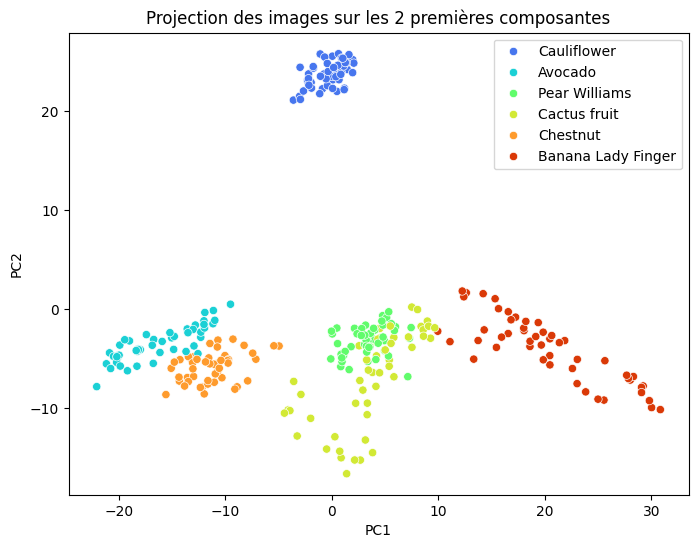

In [19]:
# Initialisation du graphique
plt.figure(figsize=(8,6))

# Construction du scatterplot
sns.scatterplot(x=X_pca[:, 0], y =X_pca[:, 1], hue=y, palette="turbo")

# AJout d'un label sur x et y
plt.xlabel("PC1")
plt.ylabel("PC2")

# Récupération des limites des axes
xlim = plt.xlim()
ylim = plt.ylim()

# AJout d'un titre
plt.title("Projection des images sur les 2 premières composantes")

# Sauvegarde
plt.savefig(f"{PATH_Result_projection}/Projection_points.png", format='png')

Le graphique représentant la projection des images de fruits sur l'espace formé par les deux premières composantes principales montre une bonne séparation des images entre les différentes espèces. Les images se regroupent en effet de manière cohérente selon leur espèce, ce qui indique que les caractéristiques extraites capturent efficacement les différences spécifiques existentes entre les images de fruits. Ces résultats sont particulièrement encourageants pour le projet de développement d’un moteur de classification d’images destiné à assister des robots cueilleurs puisque cela suggère que le système pourra distinguer automatiquement les différentes espèces de fruits avec une bonne précision.

Pour regarder comment les différentes espèces de fuits se positionnent les unes par rapport aux autres, on peut également représenter les données en utilisant le centroide de chaque espèces de fruits.

In [20]:
# Calcul du centroïde par label
centroids_df = features_pca_2d_spark.groupBy("label").agg(
    functions.avg("PC1").alias("x_centroid"),
    functions.avg("PC2").alias("y_centroid")
)

# Extraction de la première image par label
window = Window.partitionBy("label").orderBy("path")
first_images_df = features_pca_df.withColumn("rn", functions.row_number().over(window)) \
                                 .filter(functions.col("rn") == 1) \
                                 .select("label", "path")

# Jointure des centroïdes et des images
centroids_with_path = centroids_df.join(first_images_df, on="label").collect()

# Création d'un dictionnaire label -> (centroïde, image_path)
centroids = {
    row['label']: (np.array([row['x_centroid'], row['y_centroid']]), row['path'])
    for row in centroids_with_path
}

def get_image(path, zoom=0.2):
    """
    Charge une image depuis un chemin de fichier et retourne un objet OffsetImage
    utilisable pour l'affichage (par exemple dans une projection PCA).

    La fonction supprime automatiquement le préfixe ``"file:"`` du chemin, tel que
    généré par Spark, avant de charger l'image.

    Paramètres
     - path (str): Chemin vers l'image. Peut contenir le préfixe ``"file:"``.
     - zoom (float, optional (default=0.2)): Facteur de zoom appliqué à l'image lors de l'affichage.

    Sortie
     - matplotlib.offsetbox.OffsetImage:: Objet OffsetImage contenant l'image chargée, prêt à être utilisé
     dans une annotation ou un graphique matplotlib.
    """

    # Suppression de "file:" présent au début du path
    path = path[5:]

    # Ouverture de l'image
    img = Image.open(path)

    return OffsetImage(img, zoom=zoom)



25/12/15 14:15:18 WARN DAGScheduler: Broadcasting large task binary with size 1109.4 KiB
25/12/15 14:19:13 WARN DAGScheduler: Broadcasting large task binary with size 1124.5 KiB
                                                                                

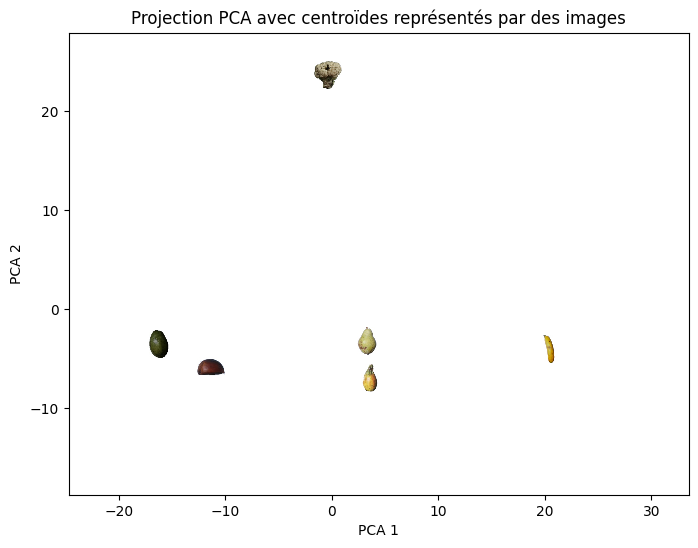

In [21]:
# Initialisation de la figure
fig, ax = plt.subplots(figsize=(8,6))

# tracer les centroïdes comme points
for label, (centroid, path) in centroids.items():
    ax.scatter(centroid[0], centroid[1], color='red', s=50)  # point rouge

# puis ajouter les images
for label, (centroid, path) in centroids.items():
    ab = AnnotationBbox(get_image(path, zoom=0.2), centroid, frameon=False)
    ax.add_artist(ab)
    
# Application des mêmes limites sur x et y que pour le première plot
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Ajout d'un titre à l'axe des x
ax.set_xlabel("PCA 1")

# AJout d'un titre à l'axe des y
ax.set_ylabel("PCA 2")

# AJout d'un titre
ax.set_title("Projection PCA avec centroïdes représentés par des images")

# Sauvegarde
plt.savefig(f"{PATH_Result_projection}/Projection_centroide.png", format='png')

# Affichage de la figure
plt.show()


Sur cet échantillon réduit comprenant seulement 6 espèces de fruits différentes, on remarque déjà un rapprochement des espèces de fruit présentant des couleurs et/ou formes similaires (poires/fruit du cactus) tandis que les espèces aux caractéristiques plus distinctes apparaissent plus éloignées (choux fleur/avocat). Néanmoins, cette représentation sera plus pertinente avec un jeu de donnée plus conséquent, mais son affichage dans cette partie a permis tester les étapes mises en place pour sa construction.

# Conclusions

Dans cette première partie, le projet a été développé en local sur une machine virtuelle Linux Ubuntu. Cette phase a permis d’installer et configurer Spark pour simuler un environnement de calcul distribué, chaque coeur de processeur étant considéré comme un worker indépendant. L’exécution des différentes traitements à réaliser sur les images de fruits dans ce context local, où un cluster de machines a été simulé, a permis de valider la solution de calcul distribué sur un jeu de données allégé. Le processus a ainsi été validé en répartissant la charge de travail sur plusieurs coeurs de processeur d’une même machine.

Travailler sur cet échantillon réduit a également permis de valider l’ensemble du processus, depuis le prétraitement des images jusqu’à l’extraction des features via transfert d'apprentissage avec le modèle MobileNetV2 choisi pour sa légèreté et sa rapidité. Les dimensions des caractéristiques extraites ont ensuite pu être réduites à l'aide d'une PCA. Les résultats ont été stockés sur le disque en partitions Parquet. La solution s’est ainsi révélée robuste et efficace dans ce contexte local. Enfin la projection des images de fruits dans un espace composé par les deux premières composantes de la PCA a permis d'observer une bonne séparation des images en fonctions des espèces de fruits présentes dans le jeu de données.

Cette première étape a donc permis à la fois de valider la chaine de traitements mis en place pour développper un moteur de classification d'images de fruits mais aussi de démontrer la possibilité de gérer l'augmentation future du volume de données. Elle permet ainsi d’envisager le déploiement des traitements à réaliser sur un environnement cloud, capable de traiter un volume de données plus important et d’exploiter pleinement les avantages d’un cluster distribué pour accélérer le traitement et simplifier la gestion des ressources.